Getting intuition of how Logistic Regression works by playing around with data in low dimensions

In [6]:
import os
import re
import datetime
import tempfile

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Understanding Logistic Regression

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## 1D

Logistic regression for dataset with only 1 variable

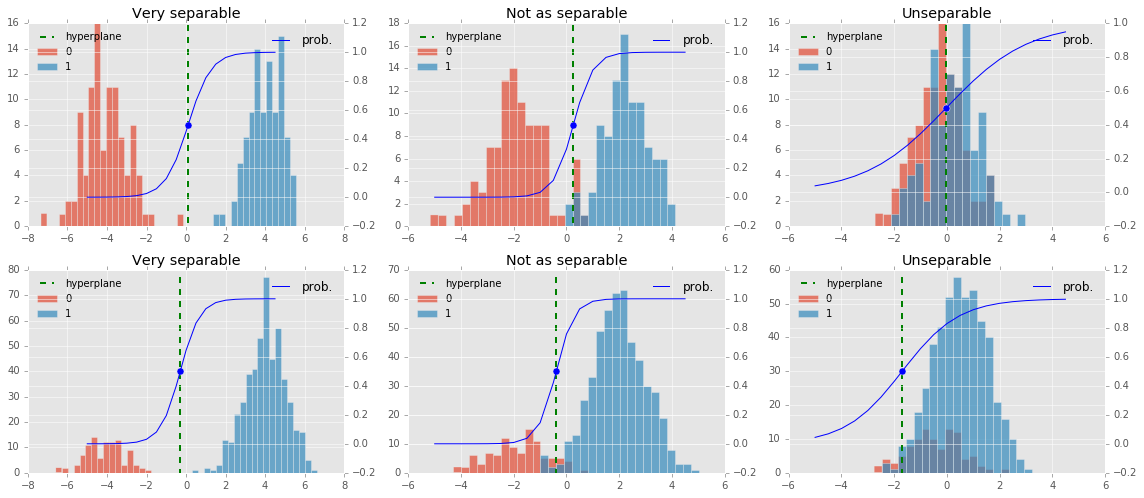

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
axes = axes.ravel()

np.random.seed(4711)
for k, (title, (size_a, mu_a, size_b, mu_b)) in enumerate(
    zip(['Very separable', 'Not as separable', 'Unseparable'] * 2,
        [
            [100, 4, 100, 4],
            [100, 2, 100, 2],
            [100, 0.5, 100, 0.5],
            
            # imbalanced dataset
            [100, 4, 500, 4],
            [100, 2, 500, 2],
            [100, 0.5, 500, 0.5],
        ])):
    # Generate sample dataset
    Xa = np.random.randn(size_a) - mu_a
    ya = np.zeros(size_a)
    Xb = np.random.randn(size_b) + mu_b
    yb = np.ones(size_b)

    X = np.concatenate([Xa, Xb]).reshape(-1, 1)
    y = np.concatenate([ya, yb])

    clf = LogisticRegression()
    clf.fit(X, y)

    cutoff = -clf.intercept_ / clf.coef_[0][0]
    
    xs = np.arange(-5, 5, 0.5)
    # explicitly calculate the sigmoid probability,
    ys = xs.reshape(-1, 1).dot(clf.coef_) + clf.intercept_
    probs = sigmoid(ys)

    # should be the same as below
    assert np.sum(np.abs(probs.ravel() - clf.predict_proba(xs.reshape(-1, 1))[:,1])) < 1e-6

    bins = np.arange(min(X), max(X), 0.3)
    ax = axes[k]
    ax.set_title(title)
    
    # draw original dataset
    _ = ax.hist(Xa, bins=bins, alpha=0.7, label='0')
    _ = ax.hist(Xb, bins=bins, alpha=0.7, label='1')

    ylim = ax.get_ylim()
    # draw hyperplane
    ax.plot([cutoff, cutoff], [-100, 100], '--', color='green', lw=2, label='hyperplane')
    ax.set_ylim(ylim)
    
    leg = ax.legend(loc='upper left', fancybox=True, fontsize=10)
    leg.get_frame().set_alpha(0)
    
    # draw sigmoid
    ax2 = ax.twinx()
    ax2.scatter([cutoff], clf.predict_proba([cutoff])[:,1], s=50)
    ax2.plot(xs, probs, label='prob.', color='blue', lw=1)
    leg2 = ax2.legend(loc='upper right')
    leg2.get_frame().set_alpha(0)

plt.tight_layout()

In the above figure, the cutoff where proability is 0.5 (not necessarily the cutoff chosen for classification theshold, you can get a more comprehensive view of how different thresholds would affect model performance with [ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) or [precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)) is shown in green. The sigmoid probabilities are in blue. The blue dot is just to emphasize where the probability equals 0.5. Histograms show the distributions of data points in two classes, respectively. You can see how probability changes as the data point moves away from the hyperplane, i.e. a dot where the green line intersect with the x axis in 1D space.

## 2D

Logistic regression for dataset with 2 variables, e.g. `x1`, `x2`

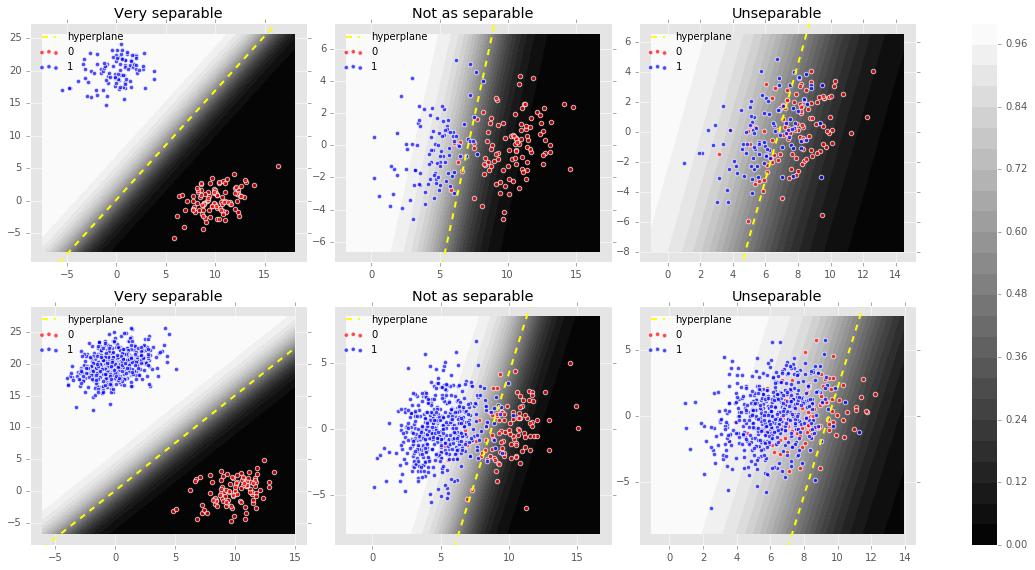

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

np.random.seed(4711)
for k, (title, (mu_a, cov_a, size_a,
                mu_b, cov_b, size_b)) in enumerate(
    zip(['Very separable', 'Not as separable', 'Unseparable'] * 2,
        [
            [[10, 0], [[3, 1], [1, 4]], [100,],  # a
             [0, 20], [[3, 1], [1, 4]], [100,]],  # b
            [[10, 0], [[3, 1], [1, 4]], [100,],
             [5, 0], [[3, 1], [1, 4]], [100,]],
            [[8, 0], [[3, 1], [1, 4]], [100,],
             [6, 0], [[3, 1], [1, 4]], [100,]],
            
            # imbalanced dataset
            [[10, 0], [[3, 1], [1, 4]], [100,],  # a
             [0, 20], [[3, 1], [1, 4]], [500,]],  # b
            [[10, 0], [[3, 1], [1, 4]], [100,],
             [5, 0], [[3, 1], [1, 4]], [500,]],
            [[8, 0], [[3, 1], [1, 4]], [100,],
             [6, 0], [[3, 1], [1, 4]], [500,]]
        ])):
    
    Xa = np.random.multivariate_normal(mu_a, cov_a, size_a)
    ya = np.zeros(size_a)
    Xb = np.random.multivariate_normal(mu_b, cov_b, size_b)
    yb = np.ones(size_b)

    X = np.concatenate([Xa, Xb]).reshape(-1, 2)
    y = np.concatenate([ya, yb])
    
    clf = LogisticRegression()
    clf.fit(X, y)
    w0 = clf.intercept_
    w1, w2 = clf.coef_[0]
    
    _x1s = np.arange(min(X[:,0]) - 2, max(X[:,0]) + 2, 0.5)
    _x2s = np.arange(min(X[:,1]) - 2, max(X[:,1]) + 2, 0.5)
    
    # for drawing hyperplane
    x1s = _x1s
    x2s = - (w0 + w1 * x1s) / w2
    
    # for drawing sigmoid probability
    xx1, xx2 = np.meshgrid(_x1s, _x2s)
    probs = sigmoid(w1 * xx1 + w2 * xx2 + w0)
    
    ax = axes[k]
    ctf = ax.contourf(xx1, xx2, probs, 30, cmap='gray', alpha=1)
    ax.scatter(Xa[:,0], Xa[:,1], color='red', alpha=0.7, edgecolors='white', linewidths=1, label='0')
    ax.scatter(Xb[:,0], Xb[:,1], color='blue', alpha=0.7, edgecolors='white', linewidths=1, label='1')
    ylim = ax.get_ylim()
    ax.plot(x1s, x2s, '--', color='yellow', lw=2, label='hyperplane')
    ax.set_ylim(ylim)
    leg = ax.legend(loc='upper left', fancybox=True, fontsize=10)
    leg.get_frame().set_alpha(0)

    ax.set_title(title)
plt.tight_layout()
fig.colorbar(ctf, ax=axes.ravel().tolist())

In the above figure, the cutoff where proability is 0.5 is shown in yellow. The sigmoid probabilities are shown as contour surface. Similarly to the 1D case, you can see how probability changes as the data point moves away from the hyperplane, i.e. a line in 2D space.

Visualize sigmoid probabilities in 3D plot to get a more concrete sense though I personally feel contour surface as shown above is more straightforward to look at

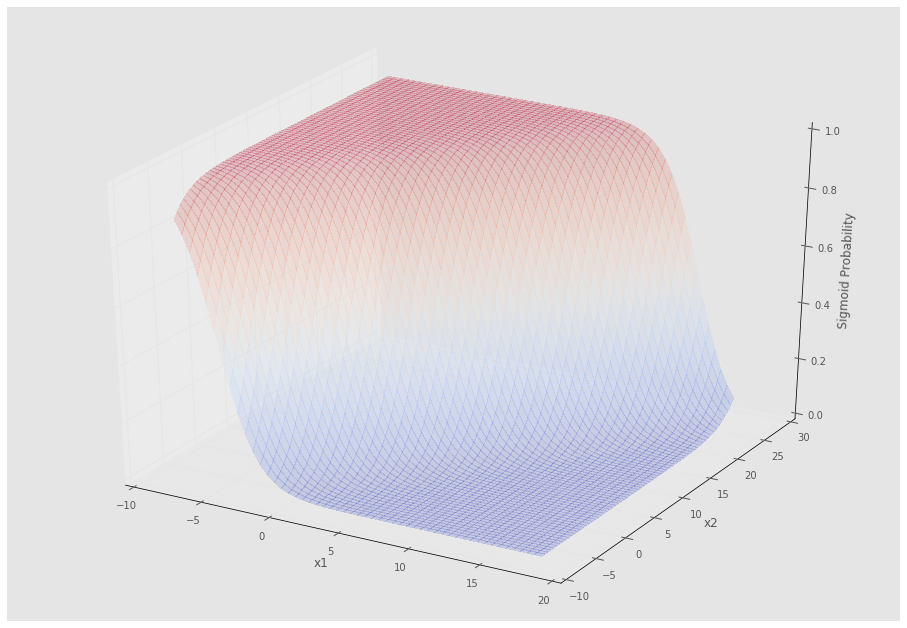

In [5]:
np.random.seed(4711)

mu_a, cov_a, size_a, mu_b, cov_b, size_b =  [
    [10, 0], [[3, 1], [1, 4]], [100,],  # a
    [0, 20], [[3, 1], [1, 4]], [100,],  # b
]

Xa = np.random.multivariate_normal(mu_a, cov_a, size_a)
ya = np.zeros(size_a)
Xb = np.random.multivariate_normal(mu_b, cov_b, size_b)
yb = np.ones(size_b)

X = np.concatenate([Xa, Xb]).reshape(-1, 2)
y = np.concatenate([ya, yb])

clf = LogisticRegression()
clf.fit(X, y)
w0 = clf.intercept_
w1, w2 = clf.coef_[0]

_x1s = np.arange(min(X[:,0]) - 2, max(X[:,0]) + 2, 0.5)
_x2s = np.arange(min(X[:,1]) - 2, max(X[:,1]) + 2, 0.5)

# for drawing hyperplane
x1s = _x1s
x2s = - (w0 + w1 * x1s) / w2

# for drawing sigmoid probability
xx1, xx2 = np.meshgrid(_x1s, _x2s)
probs = sigmoid(w1 * xx1 + w2 * xx2 + w0)

fig = plt.figure(figsize=(16, 11))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx1, xx2, probs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Sigmoid Probability')